In [1]:
# import [package name] as [name abbr.]
# python 處理數字跟 tensor 運算的主要套件
import numpy as np
import math
# google 的 NN coding 套件
import tensorflow as tf

# 監控進程的套件
from tqdm import tqdm

# Data frame 的好用套件
import pandas

# 有可能會出現警告，但是可以不用理他
# c:\users\silver\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36:
# FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating`
# is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
# from ._conv import register_converters as _register_converters
import matplotlib.pyplot as plt
import utils

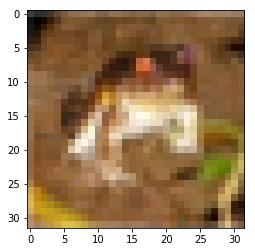

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000,)
testing file ./cifar_10/test_batch
dim(data) (10000, 3072)
dim(labels) (10000,)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000,)


In [2]:
# set dataset path
dataset_path = './cifar_10/'
height, width, dim = 32, 32, 3
classes = 10
X_train, X_test, Y_train, Y_test = utils.read_dataset(dataset_path, "img") 

In [3]:
# Define Model Input (x) and Output (y_),  y_ = f(x)
x = tf.placeholder(tf.float32, [None, height, width, dim])
y_ = tf.placeholder(tf.int32, [None])
phase_train = tf.placeholder(tf.bool, name='phase_train')
y_one = tf.one_hot(y_,classes)

In [4]:
ds_cnn1 = tf.layers.conv2d(inputs=x,
                           filters=32,
                           kernel_size=[3, 3],
                           strides=1,
                           padding="same")
ds_cnn1_act = tf.nn.relu(ds_cnn1)
ds_cnn1_bn = tf.layers.batch_normalization(ds_cnn1_act,training=phase_train)

ds_cnn2 = tf.layers.conv2d(inputs=ds_cnn1_bn,
                           filters=32,
                           kernel_size=[3, 3],
                           strides=1,
                           padding="same")
ds_cnn2_act = tf.nn.relu(ds_cnn2)
ds_cnn2_bn = tf.layers.batch_normalization(ds_cnn2_act,training=phase_train)

ds_concate1 = tf.concat([ds_cnn1_bn, ds_cnn2_bn], axis = 3)

ds_cnn3 = tf.layers.conv2d(inputs=ds_cnn2_bn,
                           filters=32,
                           kernel_size=[3, 3],
                           strides=1,
                           padding="same")
ds_cnn3_act = tf.nn.relu(ds_cnn3)
ds_cnn3_bn = tf.layers.batch_normalization(ds_cnn3_act,training=phase_train)

ds_concate2 = tf.concat([ds_cnn1_bn, ds_cnn2_bn,ds_cnn3_bn], axis = 3)

ds_cnn4 = tf.layers.conv2d(inputs=ds_concate2,
                           filters=32,
                           kernel_size=[3, 3],
                           strides=1,
                           padding="same")
ds_cnn4_act = tf.nn.relu(ds_cnn4)
ds_cnn4_bn = tf.layers.batch_normalization(ds_cnn4_act,training=phase_train)

ds_maxpool1 = tf.layers.max_pooling2d(ds_cnn4_bn,
                                      pool_size=[2,2],
                                      strides=2,
                                      padding='same')

features = tf.layers.flatten(ds_maxpool1)

ds_h1 = tf.layers.dense(features,512,activation=None)
ds_h1_act = tf.nn.relu(ds_h1)
ds_h1_bn = tf.layers.batch_normalization(ds_h1_act,training=phase_train)
ds_y = tf.layers.dense(ds_h1_bn,classes,activation=None)

ds_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_one, logits=ds_y))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
ds_train_step = tf.train.AdamOptimizer(0.001).minimize(ds_loss)

# Accuracy of the Model
ds_y_pred = tf.argmax(tf.nn.softmax(ds_y), 1, output_type=tf.int32)
ds_correct = tf.equal(ds_y_pred, y_)
ds_accuracy = tf.reduce_mean(tf.cast(ds_correct, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [5]:
# initialize the models
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
tf.global_variables_initializer().run()

In [6]:
epoch = 10
batch_size = 128
get_train_batches = utils.gen_batches(X_train, Y_train, batch_size)
get_valid_batches = utils.gen_batches(X_test, Y_test, batch_size)
batches_in_a_epoch = int(X_train.shape[0]/batch_size)

In [7]:
ds_hist_train_acc = []
ds_hist_valid_acc = []
ds_hist_train_loss = []
ds_hist_valid_loss = []

for step in tqdm(range(epoch*batches_in_a_epoch)):
    batch_train_xs, batch_train_ys = next(get_train_batches)
    batch_valid_xs, batch_valid_ys = next(get_valid_batches)
    sess.run([ds_train_step,update_ops], feed_dict={x: batch_train_xs, y_: batch_train_ys, phase_train:True})
    if (step % batches_in_a_epoch == 0):
        # trainin and validation evaluation
        train_loss, train_acc = sess.run([ds_loss,ds_accuracy], feed_dict={x: batch_train_xs, y_:batch_train_ys, phase_train:False})
        valid_loss, valid_acc = sess.run([ds_loss,ds_accuracy], feed_dict={x: batch_valid_xs,  y_: batch_valid_ys, phase_train:False})
        ds_hist_train_acc.append(train_acc)
        ds_hist_valid_acc.append(valid_acc)
        ds_hist_train_loss.append(train_loss)
        ds_hist_valid_loss.append(valid_loss)
        #print("Accuracy: [T] %.4f / [V] %.4f" % (train_acc,valid_acc))
sess.close()

100%|██████████████████████████████████████████████████████████████████████████████| 3900/3900 [10:52<00:00,  5.97it/s]


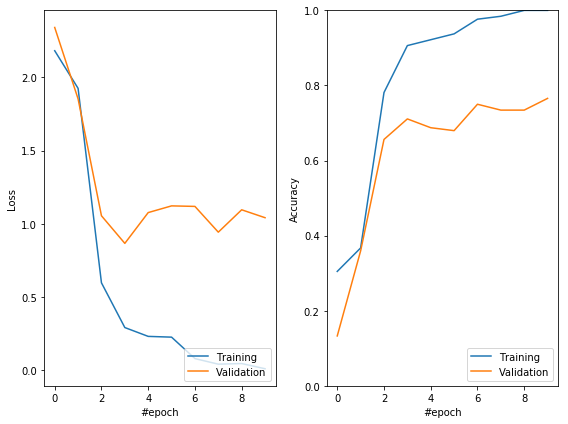

In [8]:
plt.figure(0,figsize=(8,6))
plt.subplot(121)
x = [x for x in range(len(ds_hist_valid_loss))]
line_train, = plt.plot(x, ds_hist_train_loss, label='Training')
line_valid, = plt.plot(x, ds_hist_valid_loss, label='Validation')
plt.xlabel('#epoch')
plt.ylabel('Loss')
#plt.ylim([0,2])
plt.legend(handles=[line_train,line_valid], loc=4)
plt.subplot(122)
x = [x for x in range(len(ds_hist_valid_acc))]
line_train, = plt.plot(x, ds_hist_train_acc, label='Training')
line_valid, = plt.plot(x, ds_hist_valid_acc, label='Validation')
plt.xlabel('#epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(handles=[line_train,line_valid], loc=4)
plt.tight_layout()
plt.savefig('./training_curve/ex02_DenseStructure.png',dpi=300,format='png')
plt.show()
plt.close()

In [9]:
# 存入.csv檔
res = pandas.DataFrame({"val_acc":ds_hist_valid_acc,
                        "val_loss":ds_hist_valid_loss,
                        "acc":ds_hist_train_acc,
                        "loss":ds_hist_train_loss})
res.to_csv('./training_curve/ex02_DenseStructure.csv',index=False)